# Gavleston Testbed Worflow to replicate
### Multi-hazard socio-physical resilience assessment of hurricane-induced hazards on coastal communities

Nofal, O. M., Amini, K., Padgett, J. E., van de Lindt, J. W., Rosenheim, N., Darestani, Y. M., ... & Duenas-Osorio, L. (2023). Multi-hazard socio-physical resilience assessment of hurricane-induced hazards on coastal communities. Resilient Cities and Structures, 2(2), 67-81. https://doi.org/10.1016/j.rcns.2023.07.003

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore import HHRSOutputProcess
from pyincore.utils.dataprocessutil import DataProcessUtil

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.combinedwindwavesurgebuildingdamage import CombinedWindWaveSurgeBuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore.analyses.capitalshocks import CapitalShocks

# Functions for visualizing the population data results as tables
#from pyincore_viz.analysis.popresultstable import PopResultsTable as poptable


In [2]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
# client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.9.0rc5


In [3]:
client.clear_cache()

## Combined Building Damage

### Wind building damage for Galveston, TX using Hurricane Ike

In [4]:
hazard_type = "hurricane"

# Galveston Hurricane Ike
#hazard_id = "5fa5a228b6429615aeea4410"

# Galveston 1% AEP Hurricane Simulation
hazard_id = "5fa5a9497e5cdf51ebf1add2"

# 500yr Hazard Event
#hazard_id = "5fa5aa19b6429615aeea4476"


# Galveston inventory data 
# bldg_dataset_id = "63053ddaf5438e1f8c517fed" # Full city
bldg_dataset_id = "63ff6b135c35c0353d5ed3ac" # Island Only
bldg_dataset_id

# Building Wind Fragility mapping
mapping_id = "62fef3a6cef2881193f2261d"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [5]:
# wind building damage
w_bldg_dmg = BuildingDamage(client)
w_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
w_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
w_bldg_dmg.set_parameter("result_name", "Galveston-wind-dmg")
w_bldg_dmg.set_parameter("hazard_type", hazard_type)
w_bldg_dmg.set_parameter("hazard_id", hazard_id)
w_bldg_dmg.set_parameter("num_cpu", 8)
w_bldg_dmg.run_analysis()

True

### Surge-Wave building damage for Galveston, TX using Hurricane Ike

In [6]:
# Surge-wave mapping
mapping_id = "6303e51bd76c6d0e1f6be080"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [7]:
# surge-wave building damage
sw_bldg_dmg = BuildingDamage(client)
sw_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
sw_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
sw_bldg_dmg.set_parameter("result_name", "Galveston-sw-dmg")
sw_bldg_dmg.set_parameter("hazard_type", hazard_type)
sw_bldg_dmg.set_parameter("hazard_id", hazard_id)
sw_bldg_dmg.set_parameter("num_cpu", 8)
sw_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Flood building damage for Galveston, TX using Hurricane Ike

In [8]:
# flood mapping
mapping_id = "62fefd688a30d30dac57bbd7"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [9]:
# flood building damage
f_bldg_dmg = BuildingDamage(client)
f_bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
f_bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
f_bldg_dmg.set_parameter("result_name", "Galveston-flood-dmg")
f_bldg_dmg.set_parameter("hazard_type", hazard_type)
f_bldg_dmg.set_parameter("hazard_id", hazard_id)
f_bldg_dmg.set_parameter("num_cpu", 8)
f_bldg_dmg.run_analysis()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

### Combine wind, wave and surge building damage

In [10]:
surge_wave_damage = sw_bldg_dmg.get_output_dataset("ds_result")
wind_damage = w_bldg_dmg.get_output_dataset("ds_result")
flood_damage = f_bldg_dmg.get_output_dataset("ds_result")

In [11]:
combined_bldg_dmg = CombinedWindWaveSurgeBuildingDamage(client)
result_name = "Galveston-combined-dmg"
combined_bldg_dmg.set_input_dataset("surge_wave_damage", surge_wave_damage)
combined_bldg_dmg.set_input_dataset("wind_damage", wind_damage)
combined_bldg_dmg.set_input_dataset("flood_damage", flood_damage)
combined_bldg_dmg.set_parameter("result_name", result_name)
combined_bldg_dmg.run_analysis()

True

In [12]:
combined_dmg = combined_bldg_dmg.get_output_dataset("ds_result")
combined_dmg_df = combined_dmg.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
combined_dmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,0.343989,2.566000e-07,0.000000e+00,0.656011,0.343989,2.566000e-07,0.000000e+00,yes
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,0.991388,7.115098e-01,5.500000e-09,0.008612,0.279878,7.115098e-01,5.500000e-09,yes
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.103800,5.700000e-09,0.000000e+00,0.896200,0.103800,5.700000e-09,0.000000e+00,yes
3,79008971-a534-4e45-9e40-43a2a904e59b,0.304082,1.609000e-07,0.000000e+00,0.695918,0.304082,1.609000e-07,0.000000e+00,yes
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0.424060,6.074000e-07,1.000000e-10,0.575940,0.424059,6.073000e-07,1.000000e-10,yes


### Archetype Mapping

In [13]:
buildings = Dataset.from_data_service(bldg_dataset_id, data_service)
bldg_gdf = buildings.get_dataframe_from_shapefile()
bldg_gdf.head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,strctid,parid,struct_typ,year_built,no_stories,a_stories,b_stories,bsmt_type,sq_foot,gsq_foot,...,ffe_elev,g_elev,archetype,arch_wind,arch_flood,arch_sw,csv_guid,csv_sector,csv_val_st,geometry
0,STf3a21b5f-0334-4d77-911f-faa9a45c92d7,0,NaN,1980,2,0,0,0,47927,0,...,3.76991,3.46511,0,15,6,15,NaN,NaN,NaN,POINT (-94.81680 29.31409)
1,ST80ab0289-8c72-4699-b12b-08ef2f2a5c91,0,NaN,1954,1,0,0,0,100796,0,...,2.26048,1.95568,0,15,6,15,NaN,NaN,NaN,POINT (-94.82295 29.29635)
2,ST7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0,NaN,1970,1,0,0,0,27121,0,...,2.68011,2.37531,0,15,6,15,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,IRetail,2435054.5,POINT (-94.82423 29.29098)
3,ST79008971-a534-4e45-9e40-43a2a904e59b,0,NaN,2002,1,0,0,0,126333,0,...,2.91465,2.60985,0,15,6,15,79008971-a534-4e45-9e40-43a2a904e59b,IProfSer,4483599,POINT (-94.84045 29.29117)
4,ST2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0,NaN,2002,1,0,0,0,114544,0,...,3.73770,3.43290,0,15,6,15,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,IRealE,282702.06,POINT (-94.84242 29.29059)


In [14]:
arch_mapping = Dataset.from_data_service("63dc1f1362b9d001e6a1b485", data_service).get_dataframe_from_csv()
arch_mapping

,arch_wind,category,cluster
0,12.0,Critical Facilities,Critical Medical - Acute Care Hospitals
1,14.0,Critical Facilities,Emergency Operations Centers
2,11.0,Critical Facilities,Critical Government - First Responder Facilities
3,NaN,Critical Facilities,"Non-ambulatory Facilities - Prisons, nursing h..."
4,NaN,Emergency Housing,Emergency Shelters
5,NaN,Emergency Housing,Residential Housing
6,NaN,Emergency Housing,SFH and Multi-family
7,NaN,Housing / Neighborhood,Critical Retail
8,13.0,Housing / Neighborhood,Religious and Spiritual Centers
9,1.0,Housing / Neighborhood,Residential Housing


In [15]:
max_dmg_state_df = DataProcessUtil.get_max_damage_state(combined_dmg_df)
max_dmg_state_df

,guid,max_prob,max_state
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,0.656011,DS_0
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,0.711510,DS_2
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.896200,DS_0
3,79008971-a534-4e45-9e40-43a2a904e59b,0.695918,DS_0
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0.575940,DS_0
...,...,...,...
29536,1ac5be10-582c-46b2-91ed-469f684bb886,0.999993,DS_3
29537,fbcfb6d6-de13-42fa-9839-d7c80afc651d,0.357067,DS_2
29538,2ee961c9-cd94-499e-b1fe-3e0220a440ea,0.545299,DS_2
29539,fa15cfbc-8a60-4a3f-b40f-7a6fada625b9,0.678298,DS_0


In [16]:
ret_json = DataProcessUtil.create_mapped_dmg_result(bldg_gdf, max_dmg_state_df, arch_mapping, "max_state", "arch_wind")
ret_json

{'by_cluster': [{'category': 'Critical Facilities',
   'cluster': 'Critical Medical - Acute Care Hospitals',
   'DS_0': 10,
   'DS_1': 5,
   'DS_2': 0,
   'DS_3': 0},
  {'category': 'Critical Facilities',
   'cluster': 'Emergency Operations Centers',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Critical Facilities',
   'cluster': 'Critical Government - First Responder Facilities',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Critical Facilities',
   'cluster': 'Non-ambulatory Facilities - Prisons, nursing homes, etc.',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'Emergency Shelters',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'Residential Housing',
   'DS_0': -1,
   'DS_1': -1,
   'DS_2': -1,
   'DS_3': -1},
  {'category': 'Emergency Housing ',
   'cluster': 'SFH and Multi-family',
   'DS

## Electric Power Pole Damage

In [17]:
# EPF fragility mapping
epf_mapping_id = "62fac92ecef2881193f22613"
epf_mapping_set = MappingSet(fragility_service.get_mapping(epf_mapping_id))

epf_dmg_hurricane_galveston = EpfDamage(client)
epf_dmg_hurricane_galveston.load_remote_input_dataset("epfs", "62fc000f88470b319561b58d")
epf_dmg_hurricane_galveston.set_input_dataset('dfr3_mapping_set', epf_mapping_set)
epf_dmg_hurricane_galveston.set_parameter("result_name", "Galveston-hurricane-epf-damage")
epf_dmg_hurricane_galveston.set_parameter("fragility_key", "Non-Retrofit Fragility ID Code")
epf_dmg_hurricane_galveston.set_parameter("hazard_type", hazard_type)
epf_dmg_hurricane_galveston.set_parameter("hazard_id", hazard_id)
epf_dmg_hurricane_galveston.set_parameter("num_cpu", 8)

# Run Analysis
epf_dmg_hurricane_galveston.run_analysis()
epf_dmg_result = epf_dmg_hurricane_galveston.get_output_dataset("result")

## Monte Carlo Failure Probability

In [18]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", combined_dmg)
mc.set_parameter("result_name", "combined_bldg_mc")
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", 10)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
mc.run_analysis()

gal_bldg_damage_mcs_samples = mc.get_output_dataset('sample_failure_state')
gal_bldg_damage_mcs_samples_df = gal_bldg_damage_mcs_samples.get_dataframe_from_csv()
gal_bldg_damage_mcs_samples_df.head()

,guid,failure
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,"1,1,1,1,1,1,1,1,1,1"
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,"0,0,0,0,0,0,0,0,0,0"
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,"1,0,1,1,1,1,1,1,1,1"
3,79008971-a534-4e45-9e40-43a2a904e59b,"1,0,1,1,1,1,1,0,1,1"
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,"1,1,1,1,0,1,0,1,1,1"


In [19]:
gal_bldg_failure_probability = mc.get_output_dataset('failure_probability')  # get buildings failure probabilities

In [20]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", epf_dmg_result)
mc.set_parameter("result_name", "epf_mc")
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", 10)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
mc.run_analysis()

gal_pole_damage_mcs_samples = mc.get_output_dataset('sample_failure_state')
gal_pole_damage_mcs_samples_df = gal_pole_damage_mcs_samples.get_dataframe_from_csv()
gal_pole_damage_mcs_samples_df.head()

,guid,failure
0,2525e200-cdc6-4fb8-9952-f17579176fd8,"1,1,1,1,1,1,1,1,1,1"
1,9180f947-26ae-40bd-85f5-83a80525f6c8,"1,1,1,1,1,1,1,1,1,1"
2,11ddc2dc-cc92-4c90-b4cc-a99b92a26f4b,"1,1,1,1,1,1,1,1,1,1"
3,9e58f196-9a2c-40b1-b722-69fa9c53c9d4,"1,1,1,1,1,1,1,1,1,1"
4,a4de2d54-b251-4a02-af0c-d12e0dc3670c,"1,1,1,1,1,1,1,1,1,1"


## Building Functionality

In [21]:
gal_bldg_func = BuildingFunctionality(client)
    
gal_bldg_func.set_input_dataset("building_damage_mcs_samples", gal_bldg_damage_mcs_samples)
gal_bldg_func.set_input_dataset("poles_damage_mcs_samples", gal_pole_damage_mcs_samples)
gal_bldg_func.load_remote_input_dataset("interdependency_dictionary", "63e5af0262d82d2f5a1058ea")

gal_bldg_func.set_parameter("result_name", "gal_mcs_functionality_probability")
gal_bldg_func.run_analysis()

gal_bldg_func_samples_df = gal_bldg_func.get_output_dataset('functionality_samples').get_dataframe_from_csv()
gal_bldg_func_samples_df.head()

,building_guid,samples
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,"1,1,1,1,1,1,1,1,1,1"
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,"0,0,0,0,0,0,0,0,0,0"
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,"1,0,1,1,1,1,1,1,1,1"
3,79008971-a534-4e45-9e40-43a2a904e59b,"1,0,0,1,0,1,1,0,1,1"
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,"1,1,1,1,0,1,0,1,1,1"


In [22]:
df_gal_bldg_func_probability = gal_bldg_func.get_output_dataset('functionality_probability').get_dataframe_from_csv()
df_gal_bldg_func_probability = df_gal_bldg_func_probability.rename(columns={"building_guid": "guid"})
func_prob_target = 0.50
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'].isna(), 'functionality'] = 1 # Assumed to be connected to an undamaged/unanalyzed power network for now.
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] <= func_prob_target, 'functionality'] = 0 # Non-Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] > func_prob_target, 'functionality'] = 1 # Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'].isna(), 'functionality_state'] = 'Functional' # Assumed to be connected to an undamaged/unanalyzed power network for now.
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] <= func_prob_target, 'functionality_state'] = 'Non-Functional' # Non-Functional
df_gal_bldg_func_probability.loc[df_gal_bldg_func_probability['probability'] > func_prob_target, 'functionality_state'] = 'Functional' # Functional
df_gal_bldg_func_probability.head()


,guid,probability,functionality,functionality_state
0,f3a21b5f-0334-4d77-911f-faa9a45c92d7,1.0,1.0,Functional
1,80ab0289-8c72-4699-b12b-08ef2f2a5c91,0.0,0.0,Non-Functional
2,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.9,1.0,Functional
3,79008971-a534-4e45-9e40-43a2a904e59b,0.6,1.0,Functional
4,2ad8ab6f-057f-468e-9911-6e92d9d4d01f,0.8,1.0,Functional


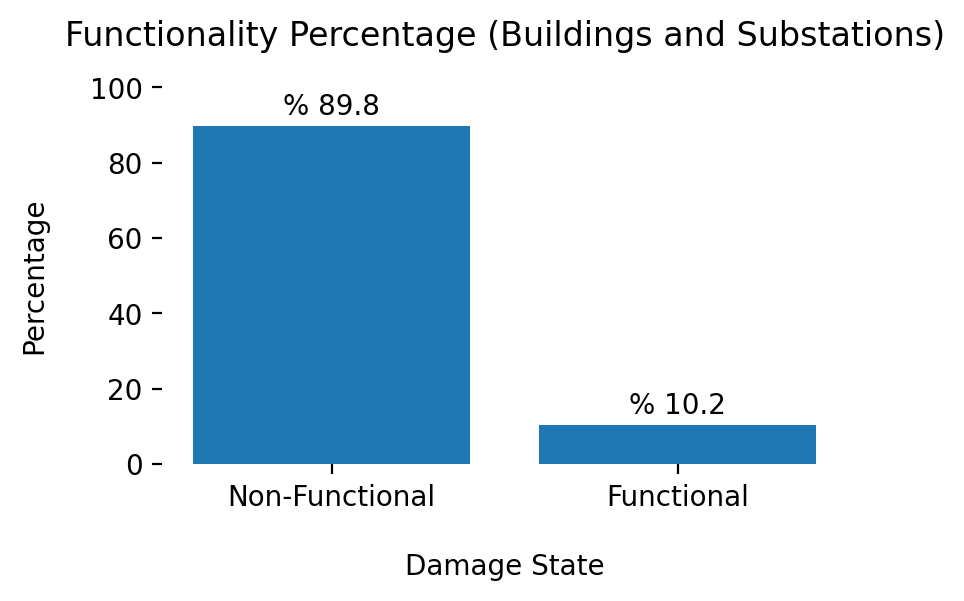

In [23]:
### Plot of the distribution of functionality state for buildings
indexes = df_gal_bldg_func_probability['functionality_state'].value_counts(normalize=True).mul(100).index.tolist()
values = df_gal_bldg_func_probability['functionality_state'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_ylim([0,100])
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Functionality Percentage (Buildings and Substations)', pad=15)
ax.set(frame_on=False);

# Capital Shocks

In [24]:
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)
building_to_sectors_id = "640200da475d895dfc2de1bd"
# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
capital_shocks.load_remote_input_dataset("buildings", bldg_dataset_id)
capital_shocks.set_input_dataset("failure_probability", gal_bldg_failure_probability)

capital_shocks.set_parameter("result_name", "sector_shocks") # name of csv file with results

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [25]:
# Run capital shocks analysis
capital_shocks.run_analysis()

sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

,sector,shock
0,HS3I,0.234928
1,HS2I,0.171255
2,HS1I,0.260163
3,IPROFSER,0.329707
4,IRETAIL,0.316591
5,IART,0.303477
6,ICONS,0.225712
7,IHEALTH,0.278540
8,ITRANS,0.217736
9,IREALE,0.415849


## Population Dislocation - Multihazard Comparison

### Setup general population data for all population dislcation results

In [26]:
pop_dis = PopulationDislocation(client)
value_loss = "60354810e379f22e16560dbd"
bg_data = "603545f2dcda03378087e708"
# hua_result_id = "63ee615d62b9d001e6a2b660" # city
hua_result_id = "63ff8e895367c2261b4cb2ef" # island

pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)
pop_dis.load_remote_input_dataset("housing_unit_allocation", hua_result_id)

### Initial loop for dislocation
The following code is used to create a set of dateframes for each hazard type and the combined damage. Each data frame has details on the population dislocation for the hazard.

In [27]:
# Create an empty dictionary to store the results
popdis_results_df = {}
popdis_results_df_mincols = {}
damage_types = {"flood_damage" : flood_damage,
                "wind_damage" : wind_damage,
                "surge_wave_damage" : surge_wave_damage,
                "combined_dmg" : combined_dmg}

# loop through the damage types
for damage, damage_result in damage_types.items():
    pop_dis.set_input_dataset("building_dmg", damage_result)

    result_name = f"galveston-pop-disl-results_{damage}"
    seed = 1111

    pop_dis.set_parameter("result_name", result_name)
    pop_dis.set_parameter("seed", seed)
    pop_dis.run_analysis()

    population_dislocation_result = pop_dis.get_output_dataset("result")
    popdis_results_df[damage] = population_dislocation_result.get_dataframe_from_csv(low_memory=False)

    # Keep HUID, prdis and dislocated columns
    popdis_results_df_mincols[damage] = popdis_results_df[damage][['guid','huid', 'prdis', 'dislocated']]

    # Print the number of dislocated housholds by HUID
    print(f"For {damage} ",popdis_results_df_mincols[damage]['dislocated'].sum(), " households are dislocated")

For flood_damage  10067  households are dislocated
For wind_damage  14292  households are dislocated
For surge_wave_damage  10007  households are dislocated
For combined_dmg  14896  households are dislocated


### Clean and merge dislocation data
The following code loops through the damage type dataframes, cleans up the columns and prepares the data for a merge.

In [28]:
popdis_merge_df = {}
# loop through the damage types
for damage, damage_result in damage_types.items():
    # Read in CSV and convert to dataframe
    damage_df = damage_result.get_dataframe_from_csv(low_memory=False)
    # For each damage type merge damage states and hazard exposure
    popdis_merge_df[damage] = pd.merge(
                                right = popdis_results_df_mincols[damage], 
                                left = damage_df[['guid','DS_0','DS_1','DS_2','DS_3','haz_expose']], 
                                left_on='guid', 
                                right_on='guid', 
                                how='right')

    # flag observations with damage exposure
    condition1 = (popdis_merge_df[damage]['haz_expose'] == 'yes')
    popdis_merge_df[damage][f'{damage}_exp'] = np.where((condition1), 1, 0)

    # flag observations that are not dislocated and DS_3 > .5
    # households that do not dislocate but have a high probability of damage
    condition1 = (popdis_merge_df[damage]['dislocated'] == 0)
    condition2 = (popdis_merge_df[damage]['DS_3'] > .5)
    popdis_merge_df[damage]['dsds3flag'] = np.where((condition1) & (condition2), 1, 0)

    # flag observations that are dislocated and DS_0 > .5
    # households that dislocate but have a low probability of damage
    condition1 = (popdis_merge_df[damage]['dislocated'] == 1)
    condition2 = (popdis_merge_df[damage]['DS_0'] > .5)
    popdis_merge_df[damage]['dsds0flag'] = np.where((condition1) & (condition2), 1, 0)

    # rename popdis_merge_df with damage type
    popdis_merge_df[damage] = popdis_merge_df[damage].rename(columns={"dsds3flag" : f"dsds3flag_{damage}",
                                                                     "dsds0flag" : f"dsds0flag_{damage}",
                                                                     "guid" : f"guid_{damage}",
                                                                     "prdis" : f"prdis_{damage}",
                                                                     "dislocated" : f"dislocated_{damage}",
                                                                     "DS_0": f"DS_0_{damage}",
                                                                     "DS_1": f"DS_1_{damage}",  
                                                                     "DS_2": f"DS_2_{damage}",
                                                                     "DS_3": f"DS_3_{damage}",
                                                                     "haz_expose": f"haz_expose_{damage}"})

   

# merge all the damage types
popdis_multihazard_df = pd.merge(right = popdis_merge_df['flood_damage'],
                                    left = popdis_merge_df['wind_damage'],
                                    left_on='huid',
                                    right_on='huid',
                                    how='outer')
popdis_multihazard_df = pd.merge(right = popdis_multihazard_df,
                                    left = popdis_merge_df['surge_wave_damage'],
                                    left_on='huid',
                                    right_on='huid',
                                    how='outer')                              
popdis_multihazard_df = pd.merge(right = popdis_multihazard_df,
                                    left = popdis_merge_df['combined_dmg'],
                                    left_on='huid',
                                    right_on='huid',
                                    how='outer')
# drop all the guid columns and rename guid_x to guid
popdis_multihazard_df = popdis_multihazard_df.drop(columns=['guid_flood_damage','guid_wind_damage','guid_surge_wave_damage'])
popdis_multihazard_df = popdis_multihazard_df.rename(columns={"guid_combined_dmg" : "guid"})   

In [29]:
popdis_multihazard_df.columns
#popdis_multihazard_df.to_csv('./output/building/dislocation_results/dislocation_building.csv', index=False)

Index(['guid', 'DS_0_combined_dmg', 'DS_1_combined_dmg', 'DS_2_combined_dmg',
       'DS_3_combined_dmg', 'haz_expose_combined_dmg', 'huid',
       'prdis_combined_dmg', 'dislocated_combined_dmg', 'combined_dmg_exp',
       'dsds3flag_combined_dmg', 'dsds0flag_combined_dmg',
       'DS_0_surge_wave_damage', 'DS_1_surge_wave_damage',
       'DS_2_surge_wave_damage', 'DS_3_surge_wave_damage',
       'haz_expose_surge_wave_damage', 'prdis_surge_wave_damage',
       'dislocated_surge_wave_damage', 'surge_wave_damage_exp',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'DS_0_wind_damage', 'DS_1_wind_damage', 'DS_2_wind_damage',
       'DS_3_wind_damage', 'haz_expose_wind_damage', 'prdis_wind_damage',
       'dislocated_wind_damage', 'wind_damage_exp', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'DS_0_flood_damage', 'DS_1_flood_damage',
       'DS_2_flood_damage', 'DS_3_flood_damage', 'haz_expose_flood_damage',
       'prdis_flood_damage', 'dislocate

# MERGE IN KOOSHAN DATA PLACEHOLDER

In [30]:
# read in Kooshan CSV file
networkdamage_df = pd.read_csv("./output/final_inf_result/final_df_with_building.csv")
# keep guid, power_back_time, transpo_back_time
networkdamage_df = networkdamage_df[['guid','average_power_back_time','average_transpo_back_time']]
# Considering with and without power/transpo in the next analyses
#networkdamage_df['average_transpo_back_time'] = 0.0   # be careful of this!
#networkdamage_df['average_power_back_time'] = 0.0   # be careful of this!
networkdamage_df.head()

,guid,average_power_back_time,average_transpo_back_time
0,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.000,0.0
1,42167885-ea18-41b4-be8c-5c09c330d312,5.836,0.0
2,3dab0b4b-42eb-4df6-a5e1-c1882df41704,0.000,0.0
3,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0
4,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0


In [31]:
networkdamage_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

In [32]:
networkdamage_df.head()

,guid,average_power_back_time,average_transpo_back_time
0,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.000,0.0
1,42167885-ea18-41b4-be8c-5c09c330d312,5.836,0.0
2,3dab0b4b-42eb-4df6-a5e1-c1882df41704,0.000,0.0
3,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0
4,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0


In [33]:
popdis_multihazard_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

In [34]:
popdis_multihazard_df.head()

,guid,DS_0_combined_dmg,DS_1_combined_dmg,DS_2_combined_dmg,DS_3_combined_dmg,haz_expose_combined_dmg,huid,prdis_combined_dmg,dislocated_combined_dmg,combined_dmg_exp,...,DS_0_flood_damage,DS_1_flood_damage,DS_2_flood_damage,DS_3_flood_damage,haz_expose_flood_damage,prdis_flood_damage,dislocated_flood_damage,flood_damage_exp,dsds3flag_flood_damage,dsds0flag_flood_damage
0,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H001,0.622177,True,1,...,0.260051,0.736570,0.003375,0.000004,yes,0.393121,True,1,0,0
1,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H002,0.670762,False,1,...,0.260051,0.736570,0.003375,0.000004,yes,0.408004,False,1,0,0
2,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H003,0.661780,True,1,...,0.260051,0.736570,0.003375,0.000004,yes,0.393583,True,1,0,0
3,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H004,0.593357,True,1,...,0.260051,0.736570,0.003375,0.000004,yes,0.395271,True,1,0,0
4,0fdd9a62-74f5-4e4d-8bb6-9fcfb7142fae,0.508449,0.482023,0.000000,0.009528,yes,B481677240001010H005,0.391570,True,1,...,0.016611,0.549143,0.434234,0.000012,yes,0.506639,True,1,0,0


In [35]:
# locate if guid == 8f1a6a6b-9258-46da-85a9-7a821f3d3c07	
popdis_multihazard_df.loc[popdis_multihazard_df['guid'] == '8f1a6a6b-9258-46da-85a9-7a821f3d3c07']

,guid,DS_0_combined_dmg,DS_1_combined_dmg,DS_2_combined_dmg,DS_3_combined_dmg,haz_expose_combined_dmg,huid,prdis_combined_dmg,dislocated_combined_dmg,combined_dmg_exp,...,DS_0_flood_damage,DS_1_flood_damage,DS_2_flood_damage,DS_3_flood_damage,haz_expose_flood_damage,prdis_flood_damage,dislocated_flood_damage,flood_damage_exp,dsds3flag_flood_damage,dsds0flag_flood_damage
0,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H001,0.622177,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.393121,True,1,0,0
1,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H002,0.670762,False,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.408004,False,1,0,0
2,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H003,0.661780,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.393583,True,1,0,0
3,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H004,0.593357,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.395271,True,1,0,0
5,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H006,0.642003,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.394106,True,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21732,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H063,0.645368,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.393203,False,1,0,0
32918,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H064,0.677073,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.418829,True,1,0,0
32919,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H065,0.639539,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.393073,True,1,0,0
32920,8f1a6a6b-9258-46da-85a9-7a821f3d3c07,0.132386,0.133041,0.525913,0.208659,yes,B481677240001010H066,0.606139,True,1,...,0.260051,0.73657,0.003375,0.000004,yes,0.395887,False,1,0,0


In [36]:
# for network df keep only the first unique guid
networkdamage_df = networkdamage_df.drop_duplicates(subset=['guid'], keep='first')
networkdamage_df['guid'].describe()

count                                    22015
unique                                   22015
top       7916eaa8-0bfa-4b32-84ff-20f19a520f5c
freq                                         1
Name: guid, dtype: object

In [41]:
# merge network damage with popdis_multihazard_df by guid
popdis_multihazard_network_df = pd.merge(right = popdis_multihazard_df,
                                    left = networkdamage_df,
                                    left_on='guid',
                                    right_on='guid',
                                    how='inner')
popdis_multihazard_network_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

In [42]:
popdis_multihazard_network_df.head()

,guid,average_power_back_time,average_transpo_back_time,DS_0_combined_dmg,DS_1_combined_dmg,DS_2_combined_dmg,DS_3_combined_dmg,haz_expose_combined_dmg,huid,prdis_combined_dmg,...,DS_0_flood_damage,DS_1_flood_damage,DS_2_flood_damage,DS_3_flood_damage,haz_expose_flood_damage,prdis_flood_damage,dislocated_flood_damage,flood_damage_exp,dsds3flag_flood_damage,dsds0flag_flood_damage
0,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.000,0.0,0.896200,0.103800,5.700000e-09,0.000000,yes,B481677252002002H005,0.159950,...,0.018487,0.363633,0.617879,0.000000e+00,yes,0.323865,True,1,0,0
1,42167885-ea18-41b4-be8c-5c09c330d312,5.836,0.0,0.003845,0.913508,3.717098e-02,0.045476,yes,B481677253001022H005,0.195856,...,0.003845,0.913508,0.037171,4.547581e-02,yes,0.195856,False,1,0,0
2,3dab0b4b-42eb-4df6-a5e1-c1882df41704,0.000,0.0,1.000000,0.000000,0.000000e+00,0.000000,partial,B481677241012034H091,0.000000,...,1.000000,0.000000,0.000000,0.000000e+00,yes,0.000000,False,1,0,0
3,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0,0.323617,0.175039,4.978419e-01,0.003502,yes,B481677256003002H009,0.415633,...,0.194912,0.799864,0.005224,8.600000e-09,yes,0.312440,True,1,0,0
4,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0,0.323617,0.175039,4.978419e-01,0.003502,yes,B481677256003002H013,0.419211,...,0.194912,0.799864,0.005224,8.600000e-09,yes,0.314465,False,1,0,0


## Add Flag for Power Outage and Road Closure
Choosing cutoffs for 3 days without power and 7 days without road access.

These cutoffs are arbitary and could be changed.

In [43]:
# If the power_back_time greater than 7 days then dislocated_power = 1
condition1 = (popdis_multihazard_network_df['average_power_back_time'] > 3)
popdis_multihazard_network_df['powerflag'] = np.where((condition1), 1, 0)

# if transpo_back_time greater than 14 days then dislocated_transpo = 1
condition1 = (popdis_multihazard_network_df['average_transpo_back_time'] > 7)
popdis_multihazard_network_df['transpoflag'] = np.where((condition1), 1, 0)

In [45]:
popdis_multihazard_network_df.head()

,guid,average_power_back_time,average_transpo_back_time,DS_0_combined_dmg,DS_1_combined_dmg,DS_2_combined_dmg,DS_3_combined_dmg,haz_expose_combined_dmg,huid,prdis_combined_dmg,...,safeflag_flood_damage,powerflag_wind_damage,transpoflag_wind_damage,safeflag_wind_damage,powerflag_surge_wave_damage,transpoflag_surge_wave_damage,safeflag_surge_wave_damage,powerflag_combined_dmg,transpoflag_combined_dmg,safeflag_combined_dmg
0,7916eaa8-0bfa-4b32-84ff-20f19a520f5c,0.000,0.0,0.896200,0.103800,5.700000e-09,0.000000,yes,B481677252002002H005,0.159950,...,1,0,0,0,0,0,1,0,0,0
1,42167885-ea18-41b4-be8c-5c09c330d312,5.836,0.0,0.003845,0.913508,3.717098e-02,0.045476,yes,B481677253001022H005,0.195856,...,0,1,0,0,1,0,0,1,0,0
2,3dab0b4b-42eb-4df6-a5e1-c1882df41704,0.000,0.0,1.000000,0.000000,0.000000e+00,0.000000,partial,B481677241012034H091,0.000000,...,1,0,0,1,0,0,1,0,0,1
3,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0,0.323617,0.175039,4.978419e-01,0.003502,yes,B481677256003002H009,0.415633,...,1,0,0,1,0,0,0,0,0,1
4,e474c4ef-a091-47ab-85b4-ef0459e37834,0.000,0.0,0.323617,0.175039,4.978419e-01,0.003502,yes,B481677256003002H013,0.419211,...,1,0,0,1,0,0,1,0,0,1


In [47]:
popdis_multihazard_network_df[['guid','huid']].describe()

,guid,huid
count,33302,33302
unique,22015,33302
top,2669f722-ae95-4181-90a8-9c4755b7b29c,B481677252002002H005
freq,191,1


In [104]:
damage_types.items()

dict_items([('flood_damage', <pyincore.dataset.Dataset object at 0x000002BA58002F70>), ('wind_damage', <pyincore.dataset.Dataset object at 0x000002BA586A2D60>), ('surge_wave_damage', <pyincore.dataset.Dataset object at 0x000002BA5753FD60>), ('combined_dmg', <pyincore.dataset.Dataset object at 0x000002BA4AF6DE50>)])

In [109]:
# loop through the damage types
for damage in ['wind_damage','surge_wave_damage','flood_damage','combined_dmg']:
    # add case where dislocated = 0 but dislocated_power == 1
    condition1 = (popdis_multihazard_network_df[f'dislocated_{damage}'] == 0)
    condition2 = (popdis_multihazard_network_df['powerflag'] == 1)
    popdis_multihazard_network_df[f'powerflag_{damage}'] = \
        np.where((condition1) & (condition2), 1, 0)
    
    # add case where dislocated = 0 but dislocated_transpo == 1
    condition1 = (popdis_multihazard_network_df[f'dislocated_{damage}'] == 0)
    condition2 = (popdis_multihazard_network_df['transpoflag'] == 1)
    popdis_multihazard_network_df[f'transpoflag_{damage}'] = \
        np.where((condition1) & (condition2), 1, 0)
    
    # identify safe occupany housholds no flags
    condition1 = (popdis_multihazard_network_df[f'dislocated_{damage}'] == 0)
    condition2 = (popdis_multihazard_network_df[f'dsds3flag_{damage}'] == 0)
    condition3 = (popdis_multihazard_network_df[f'dsds0flag_{damage}'] == 0)
    condition4 = (popdis_multihazard_network_df[f'powerflag_{damage}'] == 0)
    condition5 = (popdis_multihazard_network_df[f'transpoflag_{damage}'] == 0)
    popdis_multihazard_network_df[f'safeflag_{damage}'] = \
        np.where((condition1) & (condition2) & (condition3) & (condition4) & (condition5), 1, 0)


    # how many households have hazard exposure = yes
    hazexpose = popdis_multihazard_network_df[f'{damage}_exp'].sum()
    # how many households have dsds0flag or dsds3flag true
    totaldislocation = popdis_multihazard_network_df[f'dislocated_{damage}'].sum()
    choicedislocation = popdis_multihazard_network_df[f'dsds0flag_{damage}'].sum()
    unsafe = popdis_multihazard_network_df[f'dsds3flag_{damage}'].sum()
    nopower_nodislocation = popdis_multihazard_network_df[f'powerflag_{damage}'].sum()
    notranspo_nodislocation = popdis_multihazard_network_df[f'transpoflag_{damage}'].sum()
    safe_occupancy = popdis_multihazard_network_df[f'safeflag_{damage}'].sum()
    print(f"{damage} Number of households with hazard exposure: {hazexpose}")
    print(f"{damage} Total number of dislocated households: {totaldislocation}")
    print(f"{damage} Choice Dislocation: {choicedislocation}")
    print(f"{damage} Unsafe Occupancy: {unsafe}")
    print(f"{damage} Not dislocate and have no power: {nopower_nodislocation}")
    print(f"{damage} Not dislocate and have no connectivity to mainland: {notranspo_nodislocation}")
    print(f"{damage} Safe occupancy: {safe_occupancy}")

wind_damage Number of households with hazard exposure: 33295
wind_damage Total number of dislocated households: 14292
wind_damage Choice Dislocation: 1989
wind_damage Unsafe Occupancy: 412
wind_damage Not dislocate and have no power: 3307
wind_damage Not dislocate and have no connectivity to mainland: 3802
wind_damage Safe occupancy: 14446
surge_wave_damage Number of households with hazard exposure: 30463
surge_wave_damage Total number of dislocated households: 10007
surge_wave_damage Choice Dislocation: 1391
surge_wave_damage Unsafe Occupancy: 293
surge_wave_damage Not dislocate and have no power: 4514
surge_wave_damage Not dislocate and have no connectivity to mainland: 5372
surge_wave_damage Safe occupancy: 17140
flood_damage Number of households with hazard exposure: 32964
flood_damage Total number of dislocated households: 10067
flood_damage Choice Dislocation: 1190
flood_damage Unsafe Occupancy: 94
flood_damage Not dislocate and have no power: 4821
flood_damage Not dislocate and 

## Modify dislocation for HHSR
The HHSR model assumes that if a household dislocates then the structure is not safe to occupy and will take time to recover. However, the dislocation model has households that dislocate but the structure has a high probability of being safe to occupy. Vice versa, the model also has households that do not dislcate but the structure has a high probability of being unsafe to occupy.

If a household has choice dislocation (dsds0flag_) then dislocation should be set to 0. 

If a household has unsafe occupancy (dsds3flag_) then dislocation should be set to 1.

In [177]:
popdis_hhrs_df = popdis_multihazard_network_df.copy()

In [178]:
# loop through the damage types
for damage, damage_result in damage_types.items():
    # update dislocation if dsds0flag_ = 1
    totaldislocation1 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    condition1 = (popdis_hhrs_df[f'dsds0flag_{damage}'] == 1)
    popdis_hhrs_df[f'dislocated_{damage}'] = \
        np.where((condition1), 0, popdis_hhrs_df[f'dislocated_{damage}'])
    totaldislocation2 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    print(f"{damage} Swith Choice Dislocation Total number of dislocated households: {totaldislocation1} {totaldislocation2}")

    # update dislocation if dsds3flag_ = 1
    totaldislocation1 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    condition1 = (popdis_hhrs_df[f'dsds3flag_{damage}'] == 1)
    popdis_hhrs_df[f'dislocated_{damage}'] = \
        np.where((condition1), 1, popdis_hhrs_df[f'dislocated_{damage}'])
    totaldislocation2 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    print(f"{damage} Switch unsafe occupancy Total number of dislocated households: {totaldislocation1} {totaldislocation2}")


flood_damage Swith Choice Dislocation Total number of dislocated households: 10067 8877
flood_damage Switch unsafe occupancy Total number of dislocated households: 8877 8971
wind_damage Swith Choice Dislocation Total number of dislocated households: 14292 12303
wind_damage Switch unsafe occupancy Total number of dislocated households: 12303 12715
surge_wave_damage Swith Choice Dislocation Total number of dislocated households: 10007 8616
surge_wave_damage Switch unsafe occupancy Total number of dislocated households: 8616 8909
combined_dmg Swith Choice Dislocation Total number of dislocated households: 14896 13563
combined_dmg Switch unsafe occupancy Total number of dislocated households: 13563 14288


In [179]:
popdis_hhrs_df.columns

Index(['guid', 'average_power_back_time', 'average_transpo_back_time',
       'DS_0_combined_dmg', 'DS_1_combined_dmg', 'DS_2_combined_dmg',
       'DS_3_combined_dmg', 'haz_expose_combined_dmg', 'huid',
       'prdis_combined_dmg', 'dislocated_combined_dmg', 'combined_dmg_exp',
       'dsds3flag_combined_dmg', 'dsds0flag_combined_dmg',
       'DS_0_surge_wave_damage', 'DS_1_surge_wave_damage',
       'DS_2_surge_wave_damage', 'DS_3_surge_wave_damage',
       'haz_expose_surge_wave_damage', 'prdis_surge_wave_damage',
       'dislocated_surge_wave_damage', 'surge_wave_damage_exp',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'DS_0_wind_damage', 'DS_1_wind_damage', 'DS_2_wind_damage',
       'DS_3_wind_damage', 'haz_expose_wind_damage', 'prdis_wind_damage',
       'dislocated_wind_damage', 'wind_damage_exp', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'DS_0_flood_damage', 'DS_1_flood_damage',
       'DS_2_flood_damage', 'DS_3_flood_damage', 'ha

In [180]:
# loop through the damage types to consider dislocation due to power outage and road closure
for damage, damage_result in damage_types.items():
    # update dislocation if powerflag & transpoflag = 1
    totaldislocation1 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    condition1 = (popdis_hhrs_df[f'powerflag_{damage}'] == 1)
    condition2 = (popdis_hhrs_df[f'transpoflag_{damage}'] == 1)
    popdis_hhrs_df[f'dislocated_{damage}'] = \
        np.where(((condition1) | (condition2)), 1, popdis_hhrs_df[f'dislocated_{damage}'])
    totaldislocation2 = popdis_hhrs_df[f'dislocated_{damage}'].sum()
    print(f"{damage} Total number of dislocated households without and with power and tranportation effects: {totaldislocation1} {totaldislocation2}")

flood_damage Total number of dislocated households without and with power and tranportation effects: 8971 15351
wind_damage Total number of dislocated households without and with power and tranportation effects: 12715 16867
surge_wave_damage Total number of dislocated households without and with power and tranportation effects: 8909 14771
combined_dmg Total number of dislocated households without and with power and tranportation effects: 14288 18026


In [181]:
popdis_hhrs_df.columns

Index(['guid', 'average_power_back_time', 'average_transpo_back_time',
       'DS_0_combined_dmg', 'DS_1_combined_dmg', 'DS_2_combined_dmg',
       'DS_3_combined_dmg', 'haz_expose_combined_dmg', 'huid',
       'prdis_combined_dmg', 'dislocated_combined_dmg', 'combined_dmg_exp',
       'dsds3flag_combined_dmg', 'dsds0flag_combined_dmg',
       'DS_0_surge_wave_damage', 'DS_1_surge_wave_damage',
       'DS_2_surge_wave_damage', 'DS_3_surge_wave_damage',
       'haz_expose_surge_wave_damage', 'prdis_surge_wave_damage',
       'dislocated_surge_wave_damage', 'surge_wave_damage_exp',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'DS_0_wind_damage', 'DS_1_wind_damage', 'DS_2_wind_damage',
       'DS_3_wind_damage', 'haz_expose_wind_damage', 'prdis_wind_damage',
       'dislocated_wind_damage', 'wind_damage_exp', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'DS_0_flood_damage', 'DS_1_flood_damage',
       'DS_2_flood_damage', 'DS_3_flood_damage', 'ha

In [182]:
# Keep only columns needed for HHSR
# drop all columns with flag
#popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='flag')))]
# drop all columns with DS
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='DS')))]
# drop all columns with prdis
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='prdis')))]
# drop all columns with haz_expose
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='haz_expose')))]
# drop all columns with exp
popdis_hhrs_df = popdis_hhrs_df[popdis_hhrs_df.columns.drop(list(popdis_hhrs_df.filter(regex='exp')))]
# Drop column named dislocated 
# popdis_hhrs_df = popdis_hhrs_df.drop(columns=['dislocated'])
popdis_hhrs_df.columns

Index(['guid', 'average_power_back_time', 'average_transpo_back_time', 'huid',
       'dislocated_combined_dmg', 'dsds3flag_combined_dmg',
       'dsds0flag_combined_dmg', 'dislocated_surge_wave_damage',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'dislocated_wind_damage', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'dislocated_flood_damage',
       'dsds3flag_flood_damage', 'dsds0flag_flood_damage', 'powerflag',
       'transpoflag', 'powerflag_flood_damage', 'transpoflag_flood_damage',
       'safeflag_flood_damage', 'powerflag_wind_damage',
       'transpoflag_wind_damage', 'safeflag_wind_damage',
       'powerflag_surge_wave_damage', 'transpoflag_surge_wave_damage',
       'safeflag_surge_wave_damage', 'powerflag_combined_dmg',
       'transpoflag_combined_dmg', 'safeflag_combined_dmg'],
      dtype='object')

In [183]:
popdis_results_df[damage].columns

Index(['guid', 'DS_0', 'DS_1', 'DS_2', 'DS_3', 'haz_expose', 'huid', 'blockid',
       'bgid', 'tractid', 'FIPScounty', 'numprec', 'ownershp', 'race',
       'hispan', 'family', 'vacancy', 'gqtype', 'incomegroup', 'hhinc',
       'randincome', 'poverty', 'BLOCKID10_str', 'placeNAME10', 'huestimate',
       'x', 'y', 'geometry', 'bgidstr', 'Survey', 'pblackbg', 'phispbg',
       'd_sf', 'rploss_0', 'rploss_1', 'rploss_2', 'rploss_3', 'prdis',
       'dislocated'],
      dtype='object')

In [184]:
# Adding required columns for running the HHRS model from IN-CORE 
# HHRS code in IN-CORE needs to be edited; race, hispan, ownershp data is no more required
keepvars = ['huid','blockid', 'race', 'hispan', 'ownershp', 
            'gqtype','vacancy','numprec','randincome','poverty','hhinc']
popdis_hhrs_df = pd.merge(right = popdis_results_df[damage][keepvars],
                          left = popdis_hhrs_df,
                          left_on='huid',
                          right_on='huid',
                          how='inner')

In [185]:
popdis_hhrs_df.columns

Index(['guid', 'average_power_back_time', 'average_transpo_back_time', 'huid',
       'dislocated_combined_dmg', 'dsds3flag_combined_dmg',
       'dsds0flag_combined_dmg', 'dislocated_surge_wave_damage',
       'dsds3flag_surge_wave_damage', 'dsds0flag_surge_wave_damage',
       'dislocated_wind_damage', 'dsds3flag_wind_damage',
       'dsds0flag_wind_damage', 'dislocated_flood_damage',
       'dsds3flag_flood_damage', 'dsds0flag_flood_damage', 'powerflag',
       'transpoflag', 'powerflag_flood_damage', 'transpoflag_flood_damage',
       'safeflag_flood_damage', 'powerflag_wind_damage',
       'transpoflag_wind_damage', 'safeflag_wind_damage',
       'powerflag_surge_wave_damage', 'transpoflag_surge_wave_damage',
       'safeflag_surge_wave_damage', 'powerflag_combined_dmg',
       'transpoflag_combined_dmg', 'safeflag_combined_dmg', 'blockid', 'race',
       'hispan', 'ownershp', 'gqtype', 'vacancy', 'numprec', 'randincome',
       'poverty', 'hhinc'],
      dtype='object')

In [168]:
popdis_hhrs_df['guid'].describe()

count                                    33302
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                       191
Name: guid, dtype: object

## Check Population Data

In [186]:
# Functions for visualizing the population data results as tables
from pyincore_viz.analysis.popresultstable import PopResultsTable as poptable 

In [187]:
popdis_hhrs_df[['guid','huid']].describe()

,guid,huid
count,33302,33302
unique,22015,33302
top,2669f722-ae95-4181-90a8-9c4755b7b29c,B481677252002002H005
freq,191,1


In [188]:

poptable.pop_results_table(popdis_hhrs_df, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County, TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status',
                  row_percent = '2 Renter Occupied')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%),Percent Row 2 Renter Occupied
Race Ethnicity,,,,
"1 White alone, Not Hispanic","12,675 (55.1%)","8,736 (38.2%)","21,411 (46.7%)",40.8%
"2 Black alone, Not Hispanic","2,727 (11.9%)","5,381 (23.5%)","8,108 (17.7%)",66.4%
"3 American Indian and Alaska Native alone, Not Hispanic",77 (0.3%),118 (0.5%),195 (0.4%),60.5%
"4 Asian alone, Not Hispanic",614 (2.7%),784 (3.4%),"1,398 (3.0%)",56.1%
"5 Other Race, Not Hispanic",233 (1.0%),304 (1.3%),537 (1.2%),56.6%
"6 Any Race, Hispanic","6,660 (29.0%)","7,544 (33.0%)","14,204 (31.0%)",53.1%
Total,"22,986 (100.0%)","22,867 (100.0%)","45,853 (100.0%)",49.9%


In [189]:
# group by and count vacancy
popdis_hhrs_df['vacancy'].describe()

count    33302.000000
mean         1.672002
std          2.511834
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max          7.000000
Name: vacancy, dtype: float64

In [196]:
# group by vacancy and count
popdis_hhrs_df.groupby(['vacancy']).size()

vacancy
0    20381
1     3245
2      110
3      903
4      174
5     5302
6        8
7     3179
dtype: int64

In [149]:
poptable.pop_results_table(popdis_hhrs_df, 
                  who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$59,364","$41,694","$50,109"
"2 Black alone, Not Hispanic","$21,442","$20,263","$20,637"
"3 American Indian and Alaska Native alone, Not Hispanic","$32,378","$38,722","$38,328"
"4 Asian alone, Not Hispanic","$45,974","$28,360","$32,026"
"5 Other Race, Not Hispanic","$30,375","$27,256","$29,295"
"6 Any Race, Hispanic","$37,992","$32,973","$35,212"
Total,"$46,834","$32,646","$38,882"


In [151]:
def add_unsafe(df):
    """add poverty status information to Pop dataframe.
    Args:
        df (obj): Pandas DataFrame object.
    Returns:
        object: Pandas DataFrame object.
    """
    df['Occupancy Saftey'] = "No Data"
    df['Occupancy Saftey'].notes = "Identify Households with Safe or Unsafe Occupancy"
    df.loc[(df['dsds3flag_combined_dmg'] == 1), 'Occupancy Saftey'] = "Unsafe Occupancy"
    df.loc[(df['safeflag_combined_dmg'] == 1), 'Occupancy Saftey'] = "Safe Occupancy"
    # Set variable to missing if no data- makes tables look nicer
    df.loc[(df['Occupancy Saftey'] == "No Data"),
            'Occupancy Saftey'] = np.nan
    return df

In [152]:
popdis_hhrs_df_safe = add_unsafe(popdis_hhrs_df)

In [157]:
poptable.pop_results_table(popdis_hhrs_df_safe, 
                  who = "Total Households", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = 'Household Income Group',
                  col_index = 'Occupancy Saftey',
                  row_percent = 'Unsafe Occupancy')

Occupancy Saftey,Safe Occupancy (%),Unsafe Occupancy (%),Total Households (%),Percent Row Unsafe Occupancy
Household Income Group,,,,
"1 Less than $15,000","2,283 (23.1%)",50 (16.2%),"2,333 (22.9%)",2.1%
"2 $15,000 to $24,999","1,417 (14.3%)",36 (11.7%),"1,453 (14.3%)",2.5%
"3 $25,000 to $74,999","4,128 (41.8%)",126 (40.9%),"4,254 (41.8%)",3.0%
"4 $75,000 to $99,999",921 (9.3%),32 (10.4%),953 (9.4%),3.4%
"5 $100,000 or more","1,130 (11.4%)",64 (20.8%),"1,194 (11.7%)",5.4%
Total,"9,879 (100.0%)",308 (100.0%),"10,187 (100.0%)",3.0%


In [54]:
dislocated_types = ['dislocated_flood_damage', 'dislocated_wind_damage', 'dislocated_surge_wave_damage', 'dislocated_combined_dmg']
hhrs_dislocation_dataset_names = {}
for dislocation in dislocated_types:
    popdis_hhrs_df_temp = pd.DataFrame()
    popdis_hhrs_df_temp = popdis_hhrs_df[['guid', 'huid', 'blockid', 'race', 'hispan', 'ownershp', dislocation]]
    popdis_hhrs_df_temp = popdis_hhrs_df_temp.rename(columns={dislocation: 'dislocated'})
    popdis_hhrs_df_temp['dislocated'] = popdis_hhrs_df_temp['dislocated'].astype(bool)
    popdis_hhrs_dataset = Dataset.from_dataframe(popdis_hhrs_df_temp,
                                             name=f"popdis_hhrs_dataset_{dislocation}",
                                             data_type="incore:popDislocation")
    hhrs_dislocation_dataset_names[f"popdis_hhrs_dataset_{dislocation}"] = popdis_hhrs_dataset

In [55]:
popdis_hhrs_dataset.head()

AttributeError: 'Dataset' object has no attribute 'head'

## Housing Houshold Recovery Sequentials

### Social Vulnerabilities

In [ ]:
# importing censusutils
from pyincore_data.censusutil import CensusUtil

ModuleNotFoundError: No module named 'pyincore_data'

In [ ]:
# Parameters
state = "texas"
county = "galveston"
year = 2019

In [ ]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]

In [ ]:
navs = CensusUtil.national_ave_values(year=year)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

geo_type = "block%20group:*"
# geo_type = "tract:*"
social_vulnerability_dem_factors_df = CensusUtil.demographic_factors(state_code, county_code, year=year,
                                                                      geo_type=geo_type)

# Temp fix: remove bad data point
social_vulnerability_dem_factors_df = social_vulnerability_dem_factors_df.dropna()

social_vulnerability_dem_factors = Dataset.from_dataframe(social_vulnerability_dem_factors_df,
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

csv saved as api_20230418-122605.csv
csv saved as api_20230418-122606.csv
csv saved as api_20230418-122607.csv
csv saved as api_20230418-122608.csv
csv saved as api_20230418-122609.csv
csv saved as api_20230418-122610.csv
csv saved as api_20230418-122611.csv
csv saved as api_20230418-122612.csv
csv saved as api_20230418-122613.csv
csv saved as api_20230418-122614.csv


In [ ]:
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "gal_social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vulnerability_dem_factors)

social_vulnerability.run_analysis()
sv_result = social_vulnerability.get_output_dataset("sv_result")

In [ ]:
df = sv_result.get_dataframe_from_csv()

### HHRS

In [ ]:
# Population dislocation result aggregated to the block group level.
# Transition probability matrix per social vulnerability level.
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for stage 0.
initial_probability_vector = "60f5e918544e944c3cec668b"

# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets
for keys, values in hhrs_dislocation_dataset_names.items():
    housing_recovery.set_input_dataset("population_dislocation_block", values)
    housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
    housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector) 
    
    # Chain with SV output
    housing_recovery.set_input_dataset('sv_result', sv_result)

    # Initial value to seed the random number generator to ensure replication
    seed = 1111
    # A size of the analysis time step.
    t_delta = 1.0
    # Total duration.
    t_final = 90.0    
    


    # Specify the result name
    result_name = f"housing_recovery_result_{keys}"

    # Set analysis parameters
    housing_recovery.set_parameter("result_name", result_name)
    housing_recovery.set_parameter("seed", seed)
    housing_recovery.set_parameter("t_delta", t_delta)
    housing_recovery.set_parameter("t_final", t_final)
    housing_recovery.set_parameter("num_cpu", 8)

    housing_recovery.run()
    
    result = housing_recovery.get_output_dataset("ds_result")
    hh_stagehistory_df = result.get_dataframe_from_csv()
    #timesteps = ["1", "7", "13", "25", "85"] # t0, t6, t12, t24, t84
    timesteps = ["1", "2", "3", "4", "5", "6", "7", "13", "25", "37", "49", "61", "73", "85"]
    HHRSOutputProcess.get_hhrs_stage_count(timesteps, hh_stagehistory_df,
                                           filename_json=f"hhrs_stage_count_{keys}.json")


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [ ]:
hh_stagehistory_df['guid'].describe()

count                                   345918
unique                                   22015
top       2669f722-ae95-4181-90a8-9c4755b7b29c
freq                                     36481
Name: guid, dtype: object